<a href="https://colab.research.google.com/github/etckanikama/practice-repository/blob/main/sin_prediction01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

URLの記事を参考にsin波を予測するプログラムを作成する

[RNN-sin波予測(pytorch,numpy)](https://www.atmarkit.co.jp/ait/articles/2006/19/news023_2.html)

ゴール：この記事にあるプログラムを完璧に理解し、機械学習の実装の流れをスライドにまとめて発表することをゴールとする。

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from random import uniform

# num_div:一周期を何分割するか
# cycles:周期の数
# offset:x軸（時刻）に関するオフセット
def make_data(num_div, cycles, offset=0):
    step = 2 * np.pi / num_div
    res0 = [np.sin(step * i + offset) for i in range(num_div * cycles + 1)] #2周期分の分割した正解ラベル（xのデータ）
    res1 = [np.sin(step * i + offset) + uniform(-0.02, 0.02) for i in range(num_div * cycles + 1)]# 誤差を加えたデータ
    return res0, res1

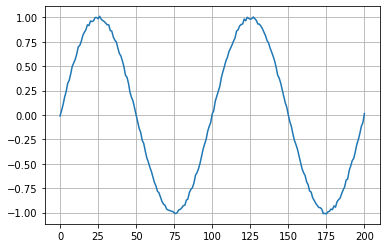

In [2]:
num_div = 100
cycles = 2

sample_data, sample_data_w_noise = make_data(num_div, cycles)#後で評価するときに使う

plt.plot(sample_data_w_noise)
plt.grid()

In [3]:
# make_data関数を呼び出したうえで、生成したデータをもとにx_train,(訓練データ)と訓練ラベルx_label(y_train)に分割する
# dataとlabelに分割する
# make_data関数で作った時系列データをnum_batchパラメータに指定された数だけスライスしてデータをずらしてまとめたのが訓練データ
def make_train_data(num_div, cycles, num_batch, offset=0):
  x,x_w_noise = make_data(num_div, cycles, offset) #x:正しいsin波のデータ,x_w_noise：ノイズの入ったsin波のデータ
  data= []
  labels = []
  count = len(x) - num_batch
  # x_w_noise:ノイズ交じりのデータをnum_batchで分割
  data = [x_w_noise[idx: idx+num_batch] for idx in range(count)] #2次元
  # x:正しいデータをnum_batchで分割
  labels = [x[idx+num_batch] for idx in range(count)] #1次元

  num_items = len(data) # 176(len(data)): count = len(x)(201) - num_batch(25)
  # data(リスト型)をテンソル型に変換：データの中身は変わらない。扱いやすいように形が変わっただけ
  # train_data,とdata[0]を見てみるとわかる
  train_data = torch.tensor(data, dtype=torch.float)
  # pytorchのrnnオブジェクトに渡せるようにするために三次元にする必要がある
  # 入力する訓練データの形状：「バッチの個数xバッチのサイズ」
  train_data = train_data.reshape(num_items, num_batch,-1)
  # labelに対しても同様の処理を行う
  train_labels = torch.tensor(labels, dtype=torch.float)
  train_labels = train_labels.reshape(num_items,-1)

  # print(len(x))
  # print(count)
  # print(len(data))

  # print(len(labels))
  return train_data,train_labels
# データを（訓練データと、正解データに分ける）
x_train,t_train = make_train_data(num_div, cycles, 25)
print(x_train.shape, t_train.shape)

torch.Size([176, 25, 1]) torch.Size([176, 1])


In [4]:
# RNNを使用するネットワークの定義
# ：詳しく知らなくてもできてしまうフレームワークのよくないところ全開

"""
RNNの挙動を確認(試すときはclass定義の下に移動させる)
# 入力x:10, hidden:20,layer=2
rnn = torch.nn.RNN(10,20,2)
# print(rnn)
# 入力ｘを作成
input = torch.randn(3,1,10)
# print(input)
# hidden:h0
h0 = torch.randn(2,1,20)
output,hn = rnn(input,h0)
print(input)

numpyのスライス
[行,列]でスライスできるので、
a = np.array([[0,1,4],[2,3,5]])
print(a[:,-1]) #行全部（:）、列後ろ（-1）
"""

out_size = 1
class Net(torch.nn.Module):
  # スーパークラスmoduleクラスのNetはサブクラスであり、スーパークラスの__init__メソッドを呼び出している
  # RNNにおいてinput_size:x,hidden_size:h,num_layers:何層にするか（デフォは１）
  def __init__(self, input_size, hidden_size,num_layers=1):
    super().__init__()
    self.rnn = torch.nn.RNN(input_size, hidden_size)
    # out:出力層のノード数：今回はsin波の値を１つだけ推測するから1になる
    self.fc = torch.nn.Linear(hidden_size, out_size) #hidden × out の行列：内積計算の総和
  def forward(self, x, hidden):
    output, h = self.rnn(x,hidden)
    output = self.fc(output[:,-1]) #output[行全部,最後の列]=最後の列一列だけ
    return output, h # output:次の層の出力、h:現在の入力をした時点での隠れ状態を表すオブジェクト









In [5]:
# 学習（ミニバッチなし）

# 初期データを分割
num_div = 100
cycles = 2
num_batch = 25
x_train, t_train = make_train_data(num_div, cycles, num_batch)

# クラスのインスタンスnetを作成
input_size = 1
hidden_size = 32
net = Net(input_size, hidden_size)

# 損失関数、最適化アルゴリズム（確率的勾配降下法(sgd)：重みの更新を行う,学習率lrを設定)
criterion = torch.nn.MSELoss() #MSE(mean squared error,平均二乗和誤差)
"""
# 要検討！！！
# 様々な評価関数（損失関数）の説明リンク：https://www.atmarkit.co.jp/ait/articles/2008/17/news031.html

# 自動で割り振った重みとバイアスを見れる&&optimizerの使い方説明
# 参考url:https://qiita.com/mathlive/items/d9f31f8538e20a102e14#6-network%E3%81%AE%E3%83%91%E3%83%A9%E3%83%A1%E3%83%BC%E3%82%BF%E9%96%B2%E8%A6%A7
# for param in net.parameters():
#   print(param)

# print(net.state_dict().keys())#これで層の名前を確認できる
# print(net.state_dict()['rnn.weight_hh_l0'])
"""
# 重みの更新を行う:学習率を設定
optimizer = torch.optim.SGD(net.parameters(), lr=0.05)

# print(optimizer.param_groups)



In [6]:
# 学習を行うプログラム

num_layers = 1
EPOCHS = 100

losses = []

for epoch in range(EPOCHS):
    print('epoch:', epoch, ', ', end='')
    # 勾配計算のやり方
    # 今回の勾配 = 前回計算した勾配　+ 今回計算した勾配
    # なので、前回計算した勾配を0で初期化する必要があるのでzero_gradで初期化する必要がある
    # つまり勾配計算であるbackward()の前にoptimizer.zero_grad()を呼び出すのが流れ的に自然になる
    optimizer.zero_grad()#要するに前回の勾配を初期化している（値は何？？）
    # RNN層の数（num_layers=1）x バッチサイズ（25） x RNNの隠れ層のサイズ(32)の０要素テンソル
    hidden = torch.zeros(num_layers, num_batch, hidden_size)
    # output:次の層の出力、h:現在の入力をした時点での隠れ状態を表すオブジェクト
    output, hidden = net(x_train, hidden)
    # 損失関数：引数：出力と,正解データ を変数lossに代入
    loss = criterion(output, t_train)
    # 今回の損失関数に関する各パラメータの勾配を計算
    loss.backward()
    # パラメータの更新：確率的勾配降下法
    optimizer.step()
    # for param in net.parameters():
    #   param.data -= lr * param.grad.data()

    # .item()でテンソル型の要素を取り出すことができる
    print(f'loss: {loss.item() / len(x_train):.6f}')
    # print(loss.item())
    losses.append(loss.item() / len(x_train))

epoch: 0 , loss: 0.002291
epoch: 1 , loss: 0.002011
epoch: 2 , loss: 0.001746
epoch: 3 , loss: 0.001487
epoch: 4 , loss: 0.001234
epoch: 5 , loss: 0.000989
epoch: 6 , loss: 0.000761
epoch: 7 , loss: 0.000559
epoch: 8 , loss: 0.000396
epoch: 9 , loss: 0.000276
epoch: 10 , loss: 0.000198
epoch: 11 , loss: 0.000153
epoch: 12 , loss: 0.000130
epoch: 13 , loss: 0.000119
epoch: 14 , loss: 0.000113
epoch: 15 , loss: 0.000109
epoch: 16 , loss: 0.000107
epoch: 17 , loss: 0.000105
epoch: 18 , loss: 0.000103
epoch: 19 , loss: 0.000101
epoch: 20 , loss: 0.000100
epoch: 21 , loss: 0.000098
epoch: 22 , loss: 0.000097
epoch: 23 , loss: 0.000095
epoch: 24 , loss: 0.000094
epoch: 25 , loss: 0.000093
epoch: 26 , loss: 0.000091
epoch: 27 , loss: 0.000090
epoch: 28 , loss: 0.000089
epoch: 29 , loss: 0.000088
epoch: 30 , loss: 0.000086
epoch: 31 , loss: 0.000085
epoch: 32 , loss: 0.000084
epoch: 33 , loss: 0.000083
epoch: 34 , loss: 0.000082
epoch: 35 , loss: 0.000081
epoch: 36 , loss: 0.000080
epoch: 37 ,

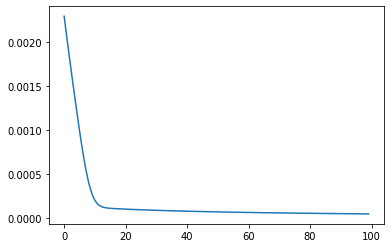

In [8]:
plt.plot(losses)

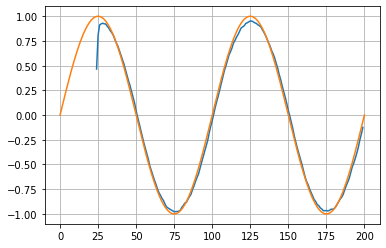

In [10]:
# detach():元のoutputに影響がないようにコピーできる
output = output.reshape(len(output)).detach()
plt.plot(range(24, 200), output)#学習によって得られた出力
plt.plot(sample_data)#make_data関数によって作成された正解のsinのグラフ:２つ目のセルにある
plt.grid()
# オレンジが正解sin,青が推測知
# 最初が欠けているのはx_trainの最初の25個については学習がないため：num_divを増やしたりすると変わる

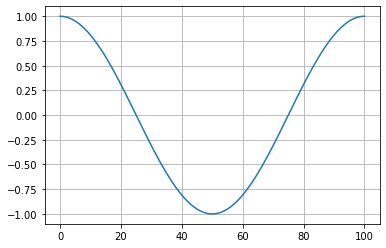

In [12]:
# 最後に違うデータで推測する
# pi/2だけオフセットしたデータを作成する：cos波と同じ
foo, bar = make_data(100,1,np.pi/2)
plt.plot(foo)
plt.grid()

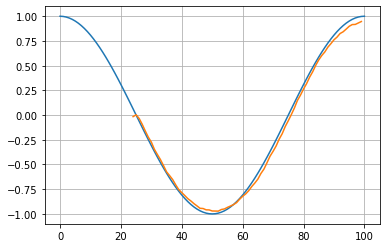

In [13]:
# これに対する訓練データをmake_train_data関数によって作成する
x_test, t_test = make_train_data(100,1,25,np.pi/2)
output2,_ = net(x_test,hidden)
plt.plot(foo)
plt.plot(range(24,100),output2.reshape(len(output2)).detach())
plt.grid()